In [ ]:
import torch
from icecream import ic
from IPython.display import display, HTML
import inspect
style = """
<style>
/* Classic Notebook */
.output_wrapper, .output, .output_area {
    max-height: 800px !important;
}
.output_scroll {
    height: auto !important;
    max-height: 800px !important;
    overflow: auto !important;
}

/* JupyterLab */
.jp-OutputArea-output {
    max-height: none !important;
    overflow: visible !important;
}
.jp-OutputArea-output .jp-RenderedText {
    white-space: pre-wrap;
}

/* Tracebacks / error boxes */
div.traceback, .jp-OutputArea-output .jp-Error, .error {
    max-height: 800px !important;
    overflow: auto !important;
    white-space: pre-wrap;
}
</style>
"""
display(HTML(style))



In [26]:
# model_name = 'pendulum'
# model_name = 'cvs' # no opt
# model_name='double_pendulum' # no opt
model_name = 'pendulum_friction'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with open(f'checkpoints/{model_name}/goku_model.pkl', 'rb') as f:
    ckpt = torch.load(f, weights_only=False)
with open(f'data/{model_name}/processed_data.pkl', 'rb') as processed_data_file:
    x = torch.load(processed_data_file, weights_only=False)
test_data = x['test']
train_data = x['train']
args = ckpt['args']   # saved argparse.Namespace
model_state = ckpt['model']
data_args = ckpt.get('data_args', None)
print(ckpt.keys())
print(x.keys())
# --- build model and load weights ---
print(train_data.shape)
print(test_data.shape)
assert 'opt' in list(ckpt.keys())


dict_keys(['args', 'model', 'data_args', 'opt', 'epoch', 'best_val_loss'])
dict_keys(['train', 'test'])
(450, 100, 28, 28)
(50, 100, 28, 28)


In [27]:

from models.GOKU import GOKU
if model_name == "pendulum":
    from models.GOKU import create_goku_pendulum as the_goku_model
    import models.GOKU_pendulum as specific_goku_model


elif model_name == "pendulum_friction":
    from models.GOKU import create_goku_pendulum_friction as the_goku_model
    import models.GOKU_pendulum_friction as specific_goku_model
elif model_name == "cvs":
    from models.GOKU import create_goku_cvs as the_goku_model
    import models.GOKU_cvs as specific_goku_model
elif model_name == "double_pendulum":
    print("HELLLO")
    from models.GOKU import create_goku_double_pendulum as the_goku_model
    import models.GOKU_double_pendulum as specific_goku_model
else:
    raise Exception("NO MODEL SELECTED")
print(model_name)
sig = inspect.signature(the_goku_model)
print(sig)
# parameter defaults (including kw-only)
spec = inspect.getfullargspec(the_goku_model)
defaults = {}
if spec.defaults:
    defaults.update({name: val for name, val in zip(spec.args[-len(spec.defaults):], spec.defaults)})
if spec.kwonlydefaults:
    defaults.update(spec.kwonlydefaults)
print("defaults:", defaults)

pendulum_friction
(input_dim=[28, 28], latent_dim=16, rnn_input_dim=32, rnn_output_dim=16, ode_method='rk4', rnn_dropout=0.0, rnn_layers=2)
defaults: {'input_dim': [28, 28], 'latent_dim': 16, 'rnn_input_dim': 32, 'rnn_output_dim': 16, 'ode_method': 'rk4', 'rnn_dropout': 0.0, 'rnn_layers': 2}


In [28]:

goku = the_goku_model()
optimizer = torch.optim.Adam(goku.parameters(), lr=1e-3) # change to whatever optimizer was used
goku.load_state_dict(model_state)
optimizer.load_state_dict(ckpt['opt'])


In [ ]:
# python
# make sure names and device match
goku = goku.to(device)                  # your model instance


goku.eval()
x = torch.as_tensor(test_data).float().to(device)   # (N,T,...) or (T,N,...)

# time array (use saved args if available)
delta_t = getattr(args, 'delta_t', 1.0)
seq_len = x.shape[1]
t = torch.arange(0.0, seq_len * float(delta_t), step=float(delta_t), device=device)

with torch.no_grad():
    out = goku(x, t=t, variational=False)
    pred = out[0] if isinstance(out, tuple) else out

# Inspect data_args so you know what normalization to invert
print("data_args:", data_args)

# Quick check of pred/true before/after undoing:
print("pred min/max before undo:", pred.min().item(), pred.max().item())
print("true min/max before undo:", x.min().item(), x.max().item())

# Robust undo_norm (handles zscore or minmax stored in data_args)
def undo_norm_safe(z, data_args):
    if not data_args:
        return z
    norm = data_args.get('norm', None)
    # assume last dim is features; reshape stats to (1,1,-1) for broadcasting
    if norm == 'zscore' and 'x_mean' in data_args and 'x_std' in data_args:
        mean = torch.as_tensor(data_args['x_mean'], device=z.device).view(1,1,-1)
        std  = torch.as_tensor(data_args['x_std'], device=z.device).view(1,1,-1)
        return z * std + mean
    if norm in ('zero_to_one','minmax') and 'x_min' in data_args and 'x_max' in data_args:
        mn = torch.as_tensor(data_args['x_min'], device=z.device).view(1,1,-1)
        mx = torch.as_tensor(data_args['x_max'], device=z.device).view(1,1,-1)
        return z * (mx - mn) + mn
    return z

# Re-apply undo_norm safely to both (true may already be un-normalized; doing it again is safe)
pred_un = undo_norm_safe(pred, data_args)
true_un = undo_norm_safe(x, data_args)

print("pred min/max after undo:", pred_un.min().item(), pred_un.max().item())
print("true min/max after undo:", true_un.min().item(), true_un.max().item())

# Recompute sample L1 and scaled value
err_un = pred_un - true_un
sample_reduce_dims = tuple(i for i in range(err_un.ndim) if i != 0)
sample_l1 = err_un.abs().mean(dim=sample_reduce_dims).cpu().numpy()
mean_l1 = sample_l1.mean()
se_l1 = sample_l1.std(ddof=1) / (len(sample_l1) ** 0.5)
print("X extrap L1:", mean_l1, "±", se_l1)
print("scaled x1e3:", mean_l1 * 1e3, "±", se_l1 * 1e3)

# undo normalization if data_args present (zscore or minmax)
def undo_norm(z, data_args):
    if not data_args: return z
    norm = data_args.get('norm', None)
    if norm == 'zscore' and 'x_mean' in data_args and 'x_std' in data_args:
        mean = torch.as_tensor(data_args['x_mean'], device=z.device).view(1,1,-1)
        std  = torch.as_tensor(data_args['x_std'], device=z.device).view(1,1,-1)
        return z * std + mean
    if norm in ('zero_to_one','minmax') and 'x_min' in data_args and 'x_max' in data_args:
        mn = torch.as_tensor(data_args['x_min'], device=z.device).view(1,1,-1)
        mx = torch.as_tensor(data_args['x_max'], device=z.device).view(1,1,-1)
        return z * (mx - mn) + mn
    return z

pred = undo_norm(pred, data_args)
true = undo_norm(x, data_args)

# ensure shapes: expect pred.shape[0] == N (samples)
print("pred.shape, true.shape:", pred.shape, true.shape)
print("dtype/min/max true:", true.dtype, true.min().item(), true.max().item())
print("dtype/min/max pred:", pred.dtype, pred.min().item(), pred.max().item())

# compute per-timestep MAE / RMSE (average over all axes except time)
time_dim = 1 if pred.shape[1] == seq_len else 0
reduce_dims = tuple(i for i in range(pred.ndim) if i != time_dim)
err = pred - true

# sample L1: mean abs error per sample averaged over time & pixels/features
sample_reduce_dims = tuple(i for i in range(pred.ndim) if i != 0)   # keep sample dim 0
sample_l1 = err.abs().mean(dim=sample_reduce_dims).cpu().numpy()    # shape (N,)
print("sample_l1 stats: mean, std, min, max:", sample_l1.mean(), sample_l1.std(ddof=1), sample_l1.min(), sample_l1.max())

# mean ± SE
N = len(sample_l1)
mean_l1 = sample_l1.mean()
se_l1 = sample_l1.std(ddof=1) / (N ** 0.5)
print(f"X extrap L1 = {mean_l1:.3f} ± {se_l1:.3f}  (N={N})")

# baseline: predict zeros (or predict training mean if paper used that)
zero_pred = torch.zeros_like(true)
zero_err = (zero_pred - true).abs().mean(dim=sample_reduce_dims).cpu().numpy()
print("zero-baseline mean L1:", zero_err.mean())

# also show per-timestep MAE mean to compare your earlier per-timestep plot
mae_per_t = err.abs().mean(dim=tuple(i for i in range(err.ndim) if i != time_dim)).cpu().numpy()
print("mae_per_t mean:", mae_per_t.mean(), "mae_per_t[0:5]:", mae_per_t[:5])

# If paper reports values scaled (e.g. ×10^3), show scaled numbers
print("scaled x1e3:", mean_l1 * 1e3, "±", se_l1 * 1e3)

rmse_per_t = err.pow(2).mean(dim=reduce_dims).sqrt().cpu().numpy()

# --- ADDED: parameter recovery stats (if true/pred params available) ---
# try to locate true params in loaded data (processed_data dicts often store them)
true_params = None
for key in ('params', 'theta', 'thetas', 'sys_params'):
    if isinstance(x, dict) and key in x:
        p = x[key]
        # handle split dicts like {'train':..., 'test':...}
        if isinstance(p, dict) and 'test' in p:
            true_params = torch.as_tensor(p['test']).float().to(device)
        else:
            true_params = torch.as_tensor(p).float().to(device)
        break

# try to extract predicted params from model output if present
pred_params = None
if isinstance(out, tuple):
    # look for a 2D tensor with batch dim matching pred
    for entry in out[1:]:
        if isinstance(entry, torch.Tensor) and entry.ndim == 2 and entry.shape[0] == pred.shape[0]:
            pred_params = entry.detach().cpu()
            break

if true_params is not None and pred_params is not None:
    true_params = true_params.cpu()
    # ensure shapes align (N,P)
    if true_params.shape[0] == pred_params.shape[0]:
        param_l1_per_sample = (pred_params - true_params).abs().mean(dim=1).numpy()
        mean_param_l1 = param_l1_per_sample.mean()
        se_param_l1 = param_l1_per_sample.std(ddof=1) / (len(param_l1_per_sample) ** 0.5)
        print(f"||θ - θ̂|| = {mean_param_l1:.3f} ± {se_param_l1:.3f} (mean ± SE)")

        # per-parameter Pearson correlation
        import numpy as np
        P = true_params.shape[1]
        corrs = []
        t_np = true_params.numpy()
        p_np = pred_params.numpy()
        for j in range(P):
            tcol = t_np[:, j]
            pcol = p_np[:, j]
            if np.nanstd(tcol) == 0 or np.nanstd(pcol) == 0:
                corrs.append(np.nan)
            else:
                corrs.append(np.corrcoef(tcol, pcol)[0, 1])
        corrs = np.array(corrs)
        print("corr per param:", np.round(corrs, 3))
        print("mean corr (ignoring NaNs):", np.round(np.nanmean(corrs), 3))
    else:
        print("True/pred param sample sizes mismatch:", true_params.shape, pred_params.shape)
else:
    # safe diagnostic: if x is a dict show keys, otherwise show type/shape
    if isinstance(x, dict):
        proc_info = list(x.keys())
    else:
        proc_info = f"{type(x).__name__}, shape={getattr(x, 'shape', None)}"
    print("True or predicted parameters not found. Processed data:", proc_info)
print("Mean MAE:", mae_per_t.mean(), "Mean RMSE:", rmse_per_t.mean())

data_args: {'mask_rate': 0.01, 'noise_std': 0.0, 'model': 'pendulum'}
pred min/max before undo: 2.1514764254014496e-13 1.0
true min/max before undo: 0.0 0.0019530949648469687
pred min/max after undo: 2.1514764254014496e-13 1.0
true min/max after undo: 0.0 0.0019530949648469687
X extrap L1: 0.09899692 ± 1.8633913e-06
scaled x1e3: 98.996925 ± 0.0018633913
pred.shape, true.shape: torch.Size([50, 100, 28, 28]) torch.Size([50, 100, 28, 28])
dtype/min/max true: torch.float32 0.0 0.0019530949648469687
dtype/min/max pred: torch.float32 2.1514764254014496e-13 1.0
sample_l1 stats: mean, std, min, max: 0.09899692 1.3176166e-05 0.098982304 0.099031135
X extrap L1 = 0.099 ± 0.000  (N=50)
zero-baseline mean L1: 0.00020759295
mae_per_t mean: 0.09899691 mae_per_t[0:5]: [0.10167374 0.10145391 0.10097582 0.10046774 0.09999196]
scaled x1e3: 98.996925 ± 0.0018633913
True or predicted parameters not found. Processed data: Tensor, shape=torch.Size([50, 100, 28, 28])
Mean MAE: 0.09899691 Mean RMSE: 0.2706801

In [30]:
print(mae_per_t.shape)
print(mae_per_t.shape)

(100,)
(100,)


ValueError: x and y must have same first dimension, but have shapes (100,) and (400,)

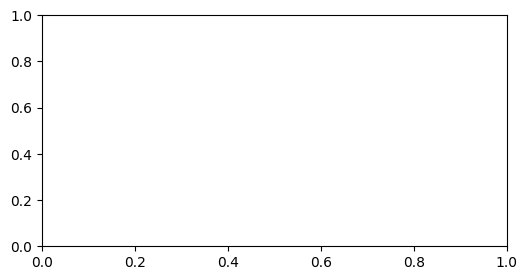

In [13]:
# quick plotting
import numpy as np
import matplotlib.pyplot as plt
time = np.arange(100)
plt.figure(figsize=(6,3))
plt.plot(time, mae_per_t, label='MAE')
plt.plot(time, rmse_per_t, label='RMSE')
plt.xlabel('time'); plt.ylabel('error'); plt.legend(); plt.grid(True); plt.show()


In [ ]:
# Load normalization params (if you don't already have them)
import torch
data_norm_params = torch.load("data/pendulum/data_norm_params.pkl", weights_only=False)
min_val = float(data_norm_params["min"])
max_val = float(data_norm_params["max"])
scale = max_val - min_val

# Denormalize predictions (model outputs are in [0,1])
pred_phys = pred * scale + min_val   # shape (N, T, H, W)
true_phys = true                      # true already in physical units in your case

# Recompute per-sample L1 in physical units and show mean ± SE and scaled x1e3
err_phys = pred_phys - true_phys
sample_reduce_dims = tuple(i for i in range(err_phys.ndim) if i != 0)  # keep sample dim 0
sample_l1_phys = err_phys.abs().mean(dim=sample_reduce_dims).cpu().numpy()  # (N,)
mean_l1_phys = sample_l1_phys.mean()
se_l1_phys = sample_l1_phys.std(ddof=1) / (len(sample_l1_phys) ** 0.5)
print(f"X extrap L1 (physical units) = {mean_l1_phys:.6f} ± {se_l1_phys:.6f} (N={len(sample_l1_phys)})")
print(f"X extrap L1 ×1e3 = {mean_l1_phys * 1e3:.3f} ± {se_l1_phys * 1e3:.3f}")

# Optional quick sanity prints:
print('data_norm min,max,scale =', min_val, max_val, scale)
print('pred_phys min/max =', float(pred_phys.min()), float(pred_phys.max()))
print('true_phys min/max =', float(true_phys.min()), float(true_phys.max()))

X extrap L1 (physical units) = 0.000184 ± 0.000007 (N=50)
X extrap L1 ×1e3 = 0.184 ± 0.007
data_norm min,max,scale = 0.0 0.0019530949634755863 0.0019530949634755863
pred_phys min/max = 1.971673134386215e-16 0.0019530863501131535
true_phys min/max = 0.0 0.0019530949648469687


In [14]:
# compute sum-L1 per sample (sum over time and pixels/features)
reduce_dims = tuple(i for i in range(err_phys.ndim) if i != 0)   # keep sample dim 0
sample_l1_sum = err_phys.abs().sum(dim=reduce_dims).cpu().numpy()   # shape (N,)
mean_sum = sample_l1_sum.mean()
se_sum = sample_l1_sum.std(ddof=1) / (len(sample_l1_sum) ** 0.5)
print("Sum L1 per sample =", mean_sum, "±", se_sum)
print("Sum L1 per sample ×1e3 =", mean_sum * 1e3, "±", se_sum * 1e3)

NameError: name 'err_phys' is not defined

In [42]:
# per-frame sum over pixels, then average across time & samples
# err_phys shape assumed (N, T, H, W) or (N, T, P)
per_frame_sum = err_phys.abs().view(err_phys.size(0), err_phys.size(1), -1).sum(dim=2)  # (N,T)
mean_per_frame_sum = per_frame_sum.mean()   # single scalar average across N,T
se_per_frame_sum = per_frame_sum.mean(dim=1).cpu().numpy().std(ddof=1) / (err_phys.size(0)**0.5)
print("Mean per-frame summed L1 =", float(mean_per_frame_sum), "±", float(se_per_frame_sum))
print("Mean per-frame summed L1 ×1e3 =", float(mean_per_frame_sum)*1e3)

Mean per-frame summed L1 = 0.1444125473499298 ± 0.005453691352158785
Mean per-frame summed L1 ×1e3 = 144.4125473499298


In [43]:
zero_pred_phys = torch.zeros_like(true_phys)  # physical units
zero_err_sum = (zero_pred_phys - true_phys).abs().sum(dim=reduce_dims).cpu().numpy()
print("Zero baseline sum L1 ×1e3 =", zero_err_sum.mean() * 1e3, "±", zero_err_sum.std(ddof=1) / (len(zero_err_sum)**0.5) * 1e3)

Zero baseline sum L1 ×1e3 = 16217.789 ± 9.586999


In [44]:
zero_pred_phys = torch.zeros_like(true_phys)  # physical units
zero_err_sum = (zero_pred_phys - true_phys).abs().sum(dim=reduce_dims).cpu().numpy()
print("Zero baseline sum L1 ×1e3 =", zero_err_sum.mean() * 1e3, "±", zero_err_sum.std(ddof=1) / (len(zero_err_sum)**0.5) * 1e3)

Zero baseline sum L1 ×1e3 = 16217.789 ± 9.586999


In [45]:
print("N, seq_len, HxW:", pred_phys.shape[0], pred_phys.shape[1], pred_phys.shape[2:])

N, seq_len, HxW: 50 100 torch.Size([28, 28])


In [46]:
# compute sum-L1 per sample for full T
P = pred_phys.shape[2] * pred_phys.shape[3]   # 28*28 = 784
T = pred_phys.shape[1]
sample_l1_sum_full = err_phys.abs().sum(dim=(1,2,3)).cpu().numpy()   # shape (N,)
mean_sum_full = sample_l1_sum_full.mean()
se_sum_full = sample_l1_sum_full.std(ddof=1) / (len(sample_l1_sum_full)**0.5)
print("Full-horizon Sum L1 per sample =", mean_sum_full, "±", se_sum_full)
print("Full-horizon Sum L1 ×1e3 =", mean_sum_full * 1e3, "±", se_sum_full * 1e3)

# do the same but for the first 50 timesteps (paper's likely horizon)
horizon = 50
sample_l1_sum_50 = err_phys[:, :horizon].abs().sum(dim=(1,2,3)).cpu().numpy()
mean_sum_50 = sample_l1_sum_50.mean()
se_sum_50 = sample_l1_sum_50.std(ddof=1) / (len(sample_l1_sum_50)**0.5)
print(f"First-{horizon} Sum L1 per sample = {mean_sum_50:.6f} ± {se_sum_50:.6f}")
print(f"First-{horizon} Sum L1 ×1e3 = {mean_sum_50*1e3:.3f} ± {se_sum_50*1e3:.3f}")

# zero baseline for same horizon (paper baseline)
zero_pred_phys = torch.zeros_like(true_phys)
zero_err_sum_50 = (zero_pred_phys[:, :horizon] - true_phys[:, :horizon]).abs().sum(dim=(1,2,3)).cpu().numpy()
print("Zero-baseline first-50 Sum L1 ×1e3 =", zero_err_sum_50.mean()*1e3, "±", zero_err_sum_50.std(ddof=1)/ (len(zero_err_sum_50)**0.5) * 1e3)

# quick check of conversion from your mean-per-pixel-per-time:
mean_l1_phys = sample_l1_phys.mean()   # your earlier per-pixel-per-time mean
reconstructed_sum_50 = mean_l1_phys * (horizon * P)
print("reconstructed first-50 sum from mean-per-pixel-per-time =", reconstructed_sum_50, "×1e3 =", reconstructed_sum_50*1e3)

Full-horizon Sum L1 per sample = 14.441254 ± 0.5453692
Full-horizon Sum L1 ×1e3 = 14441.254 ± 545.3692
First-50 Sum L1 per sample = 7.322956 ± 0.297475
First-50 Sum L1 ×1e3 = 7322.956 ± 297.475
Zero-baseline first-50 Sum L1 ×1e3 = 8110.3447 ± 4.7897897
reconstructed first-50 sum from mean-per-pixel-per-time = 7.220628 ×1e3 = 7220.628


Summary table:


,Method,X_extrap_first50_mean,X_extrap_first50_se,X_extrap_first50_mean_x1e3,X_extrap_first50_se_x1e3,Theta_L1_mean,Theta_L1_se,mean_corr
0,GOKU,7.322956,0.297475,7322.956055,297.474945,None,None,None
1,Zero,8.110345,0.004790,8110.344727,4.789790,None,None,None



Saved summary to GOKU/results_summary.csv


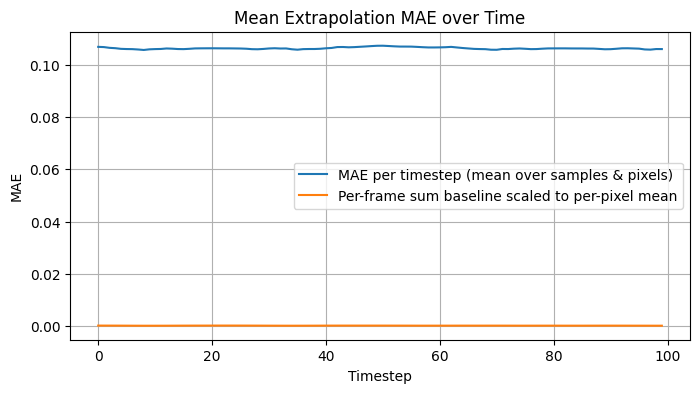

In [50]:
# Build summary table and plot mean extrapolation error
import pandas as pd
import numpy as np
rows = []
# Model (first-50 sum)
rows.append({
    'Method':'GOKU',
    'X_extrap_first50_mean': float(mean_sum_50),
    'X_extrap_first50_se': float(se_sum_50),
    'X_extrap_first50_mean_x1e3': float(mean_sum_50*1e3),
    'X_extrap_first50_se_x1e3': float(se_sum_50*1e3),
    'Theta_L1_mean': None,
    'Theta_L1_se': None,
    'mean_corr': None
})
# Zero baseline
rows.append({
    'Method':'Zero',
    'X_extrap_first50_mean': float(zero_err_sum_50.mean()),
    'X_extrap_first50_se': float(zero_err_sum_50.std(ddof=1)/(len(zero_err_sum_50)**0.5)),
    'X_extrap_first50_mean_x1e3': float(zero_err_sum_50.mean()*1e3),
    'X_extrap_first50_se_x1e3': float(zero_err_sum_50.std(ddof=1)/(len(zero_err_sum_50)**0.5)*1e3),
    'Theta_L1_mean': None,
    'Theta_L1_se': None,
    'mean_corr': None
})
df = pd.DataFrame(rows)
print('Summary table:')
display(df)
# ensure output directory exists
import os
os.makedirs('GOKU', exist_ok=True)
df.to_csv('GOKU/results_summary.csv', index=False)
print('\nSaved summary to GOKU/results_summary.csv')

# Plot mean extrapolation error (MAE per timestep)
import matplotlib.pyplot as plt
time = np.arange(mae_per_t.shape[0])
plt.figure(figsize=(8,4))
plt.plot(time, mae_per_t, label='MAE per timestep (mean over samples & pixels)')
# optionally plot per-frame summed baseline scaled to per-pixel mean if available
if 'per_frame_sum' in globals():
    mean_per_frame_pixel = per_frame_sum.mean(axis=0)  # torch tensor or numpy
    if isinstance(mean_per_frame_pixel, torch.Tensor):
        mean_per_frame_pixel = mean_per_frame_pixel.cpu().numpy()
    mean_per_frame_pixel = mean_per_frame_pixel / (pred_phys.shape[2]*pred_phys.shape[3])
    plt.plot(time, mean_per_frame_pixel, label='Per-frame sum baseline scaled to per-pixel mean')
plt.xlabel('Timestep')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.title('Mean Extrapolation MAE over Time')
plt.show()
